In [2]:
import os
import requests
from tqdm import tqdm

download_url = "https://zenodo.org/records/4737435/files/IconArt_v2.zip"
local_file_name = "IconArt.zip"

if os.path.exists(local_file_name):
  print(f"The file '{local_file_name}' already exists. Skipping download.")

else:
  print(f"Downloading the dataset from {download_url}...")
  
  head_response = requests.head(download_url)
  file_size = int(head_response.headers.get("content-length", 0))
  
  response = requests.get(download_url, stream=True)
  response.raise_for_status()
  
  with tqdm(total=file_size, unit="B", unit_scale=True, desc=local_file_name) as pbar:
    with open(local_file_name, "wb") as file:
      for chunk in response.iter_content(chunk_size=8192):
        file.write(chunk)
        pbar.update(len(chunk))  # Update progress bar
  
  print(f"Dataset downloaded and saved as '{local_file_name}'")

The file 'IconArt.zip' already exists. Skipping download.


In [3]:
import zipfile
import os

zip_file = "IconArt.zip"

old_folder_name = "IconArt_v2"
new_folder_name = "IconArt"

extract_dir = "." 

if not os.path.exists(zip_file):
    print(f"The file '{zip_file}' does not exist. Please download it first.")
elif os.path.exists(new_folder_name):
    print(f"The folder '{new_folder_name}' already exists. Skipping extraction.")
else:
    print(f"Extracting '{zip_file}' to '{extract_dir}'...")
    with zipfile.ZipFile(zip_file, 'r') as zip_ref:
        zip_ref.extractall(extract_dir)
    print(f"Extraction complete. Files are saved in '{extract_dir}'")
    
    if os.path.exists(old_folder_name):
      os.rename(old_folder_name, new_folder_name)
      print(f"Renamed '{old_folder_name}' to '{new_folder_name}'")
    else:
      print(f"The folder '{old_folder_name}' does not exist.")

The folder 'IconArt' already exists. Skipping extraction.


In [1]:
import os
import pandas as pd

dataset_folder = "IconArt"
dataset_data_folder = "IconArt-data"

# Read the CSV file
csv_file_path = os.path.join(dataset_folder, "ImageSets", "Main", "IconArt_v2.csv")
df = pd.read_csv(csv_file_path)

# Extract columns that are numbers (remove 'anno')
columns_to_keep = [col for col in df.columns if col not in ['item', 'set', 'Anno']]



# Create a dictionary from the comments
data_dict = {
  'Saint_Sebastien': ['Saint_Sebastien', '11H(SEBASTIAN)', 'The Martyr Sebastian; Possible Attributes: Arrow(s), Bow, Tree-Trunk'],
  'turban': ['turban', '41D221(TURBAN)', 'Head-Gear: Turban'],
  'crucifixion_of_Jesus': ['crucifixion_of_Jesus', '11D356', 'Christ Crucified On A \'Living\' Cross'],
  'angel': ['angel', '11G', 'Angels'],
  'capital': ['capital', '48C1612', 'Capital (~ Column, Pillar)'],
  'Mary': ['Mary', '11F', 'The Virgin Mary'],
  'beard': ['beard', '31A534', 'Beard'],
  'Child_Jesus': ['Child_Jesus', '11D2', 'Christ As Child Or Youth (In General) ~ Christian Religion'],
  'nudity': ['nudity', '31A', 'The (Nude) Human Figure; \'Corpo Humano\' (Ripa)'],
  'ruins': ['ruins', '48C149', 'Ruin Of A Building ~ Architecture']
}

# Create a new DataFrame directly from data_dict
df_new = pd.DataFrame.from_dict(data_dict, orient='index', columns=['ID', 'ICONCLASS ID', 'Description']).reset_index()
#df_new.rename(columns={'index': 'Label'}, inplace=True)
df_new['Label'] = df_new['ID'].str.replace('_', ' ').str.title()

# Save Classes
output_csv_path = os.path.join(dataset_data_folder, "classes.csv")
df_new.to_csv(output_csv_path, index=False)
print(f"DataFrame saved as '{output_csv_path}'")

# Copy test file to data folder
output_csv_path = os.path.join(dataset_data_folder, "2_test.txt")
test_file = os.path.join(dataset_folder, 'ImageSets', 'Main', "test.txt")

os.makedirs(dataset_data_folder, exist_ok=True)
with open(test_file, 'r') as src, open(output_csv_path, 'w') as dst:
  for line in src:
    dst.write(line.strip() + '\n')
print(f"Test file copied to '{output_csv_path}'")

df_new


DataFrame saved as 'IconArt-data/classes.csv'
Test file copied to 'IconArt-data/2_test.txt'


,index,ID,ICONCLASS ID,Description,Label
0,Saint_Sebastien,Saint_Sebastien,11H(SEBASTIAN),The Martyr Sebastian; Possible Attributes: Arr...,Saint Sebastien
1,turban,turban,41D221(TURBAN),Head-Gear: Turban,Turban
2,crucifixion_of_Jesus,crucifixion_of_Jesus,11D356,Christ Crucified On A 'Living' Cross,Crucifixion Of Jesus
3,angel,angel,11G,Angels,Angel
4,capital,capital,48C1612,"Capital (~ Column, Pillar)",Capital
5,Mary,Mary,11F,The Virgin Mary,Mary
6,beard,beard,31A534,Beard,Beard
7,Child_Jesus,Child_Jesus,11D2,Christ As Child Or Youth (In General) ~ Christ...,Child Jesus
8,nudity,nudity,31A,The (Nude) Human Figure; 'Corpo Humano' (Ripa),Nudity
9,ruins,ruins,48C149,Ruin Of A Building ~ Architecture,Ruins


In [12]:
import os
import json
import pandas as pd

dataset_folder = "IconArt"
dataset_data_folder = "IconArt-data"

# Define paths
image_dir = "IconArt/JPEGImages"
json_file_path = "IconArt-data/2_ground_truth.json"
csv_file_path = os.path.join(dataset_folder, "ImageSets", "Main", "IconArt_v2.csv")
test_file = os.path.join(dataset_data_folder, "2_test.txt")

# Read the CSV file
df = pd.read_csv(csv_file_path)

filtered_df = df[df[columns_to_keep].sum(axis=1) == 1]

# Print the number of images belonging to one class
print(f"Number of images belonging to one class only: {len(filtered_df)}")

# Save images in filtered_df into 2_test.txt
with open(test_file, 'w') as file:
  for item in filtered_df['item']:
    file.write(f"{item}\n")
print(f"Images with only one class are stored into '{test_file}'")
print("Creating a new test file with only images that have at least one class.")

ground_truth_data = []

for _, row in filtered_df.iterrows():
  item = row['item']
  class_name = next((col for col in columns_to_keep if row[col] == 1), None)
  if class_name:
    ground_truth_data.append({'item': item, 'class': class_name})

# Save ground truth data to JSON file
with open(json_file_path, 'w') as json_file:
  json.dump(ground_truth_data, json_file, indent=4)

print(f"Ground truth data saved to '{json_file_path}'")


Number of images belonging to one class only: 1955
Images with only one class are stored into 'IconArt-data/2_test.txt'
Creating a new test file with only images that have at least one class.
Ground truth data saved to 'IconArt-data/2_ground_truth.json'


In [13]:
# Calculate the number of images per class and convert to DataFrame
class_counts_df = filtered_df[columns_to_keep].sum().reset_index()
class_counts_df.columns = ['Class', 'Image Count']
class_counts_df['Image Count'] = class_counts_df['Image Count'].astype(int)

# Filter the test set
test_df = df[df['set'] == 'test']

class_counts_df

,Class,Image Count
0,Saint_Sebastien,68
1,turban,52
2,crucifixion_of_Jesus,12
3,angel,168
4,capital,51
5,Mary,77
6,beard,669
7,Child_Jesus,6
8,nudity,619
9,ruins,233


In [13]:
# Define the classes to detect
classes_to_detect = ['Saint_Sebastien', 'crucifixion_of_Jesus', 'capital', 'ruins', 'turban']

# Filter the dataset for the specified classes and not in the test set
filtered_df = df[(df['set'] != 'test') & (df[classes_to_detect].sum(axis=1) > 0)]

# Select 5 images for each class
selected_images = {}
for class_name in classes_to_detect:
  class_images = filtered_df[filtered_df[class_name] == 1]['item'].sample(5).tolist()
  selected_images[class_name] = class_images

selected_images

{'Saint_Sebastien': ['Q28796753',
  'Q3921912',
  'Q18574101',
  'Q27766454',
  'Q19947637'],
 'crucifixion_of_Jesus': ['Q18565915',
  'Q5189807',
  'Q41796334',
  'Q7728256',
  'Q568847'],
 'capital': ['Q3605541', 'Q19897698', 'Q18822512', 'Q3907489', 'Q26248364'],
 'ruins': ['Q19930798', 'Q22084508', 'Q19930487', 'Q19928892', 'Q19915164'],
 'turban': ['Q29871370', 'Q5482036', 'Q27968053', 'Q21997753', 'Q3224308']}

Class: Saint_Sebastien


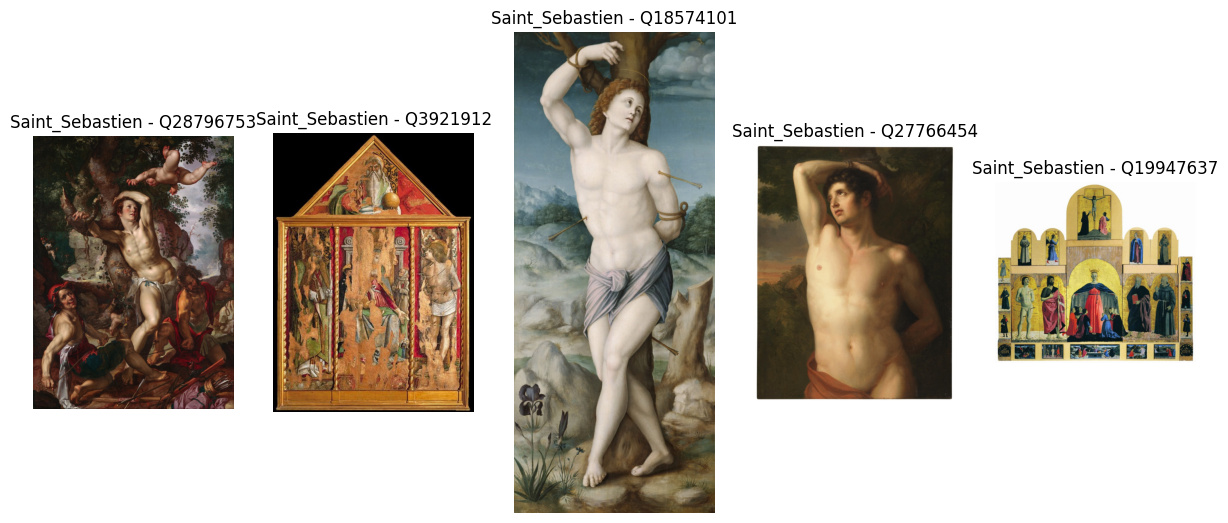

Class: crucifixion_of_Jesus


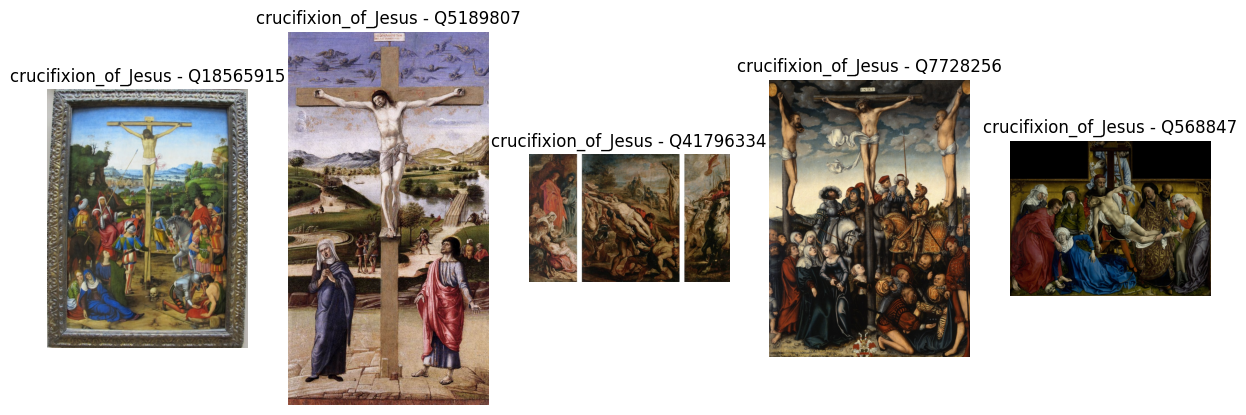

Class: capital


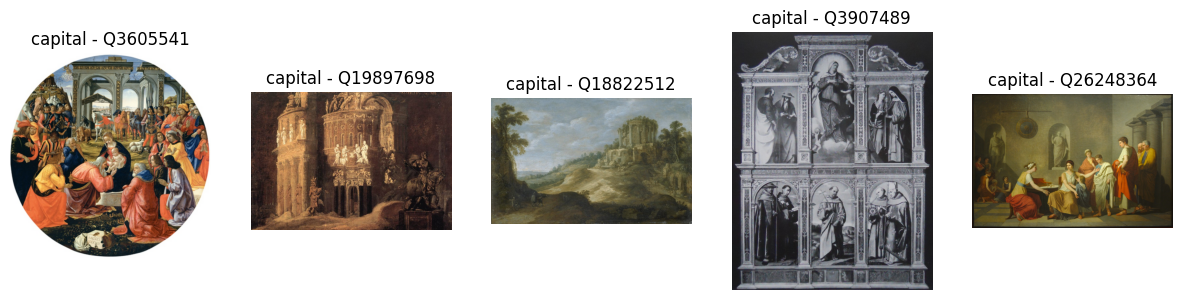

Class: ruins


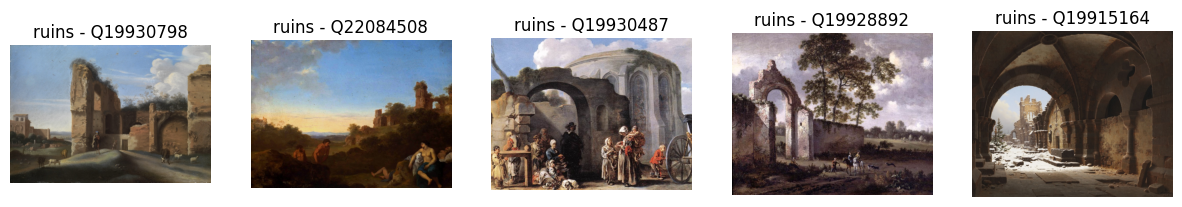

Class: turban


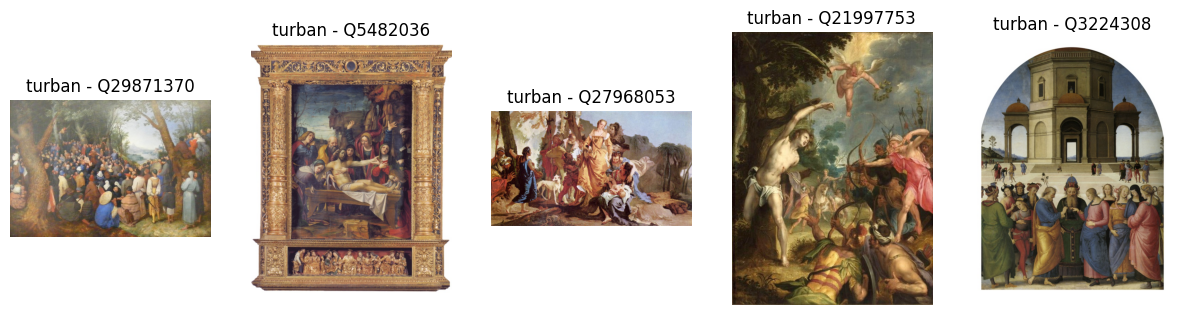

In [14]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Define the directory where images are stored
image_dir = "IconArt/JPEGImages"

# Iterate over each class in selected_images
for class_name, class_images in selected_images.items():
  print(f"Class: {class_name}")
  
  # Display the images
  plt.figure(figsize=(15, 10))
  for i, image_id in enumerate(class_images):
    img_path = os.path.join(image_dir, f"{image_id}.jpg")
    img = mpimg.imread(img_path)
    plt.subplot(1, len(class_images), i + 1)
    plt.imshow(img)
    plt.title(f"{class_name} - {image_id}")
    plt.axis('off')
  
  plt.show()


In [21]:
import os
import pandas as pd
import shutil

# List of tuples containing item and class
data_tuples = [
  ('Q18574101', 'Saint_Sebastien'),
  ('Q5189807', 'crucifixion_of_Jesus'),
  ('Q18822512', 'capital'),
  ('Q19930798', 'ruins'),
  ('Q3224308', 'turban')
]



# Convert the list of tuples to a DataFrame
train_data_df = pd.DataFrame(data_tuples, columns=['item', 'class'])

output_path = os.path.join('IconArt-data', 'few-shot')

# Ensure the destination directory exists
os.makedirs(output_path, exist_ok=True)

# Define the output CSV file path
output_csv_path = os.path.join(output_path, 'train_data.csv')

# Ensure the directory exists
os.makedirs(os.path.dirname(output_csv_path), exist_ok=True)

# Save the DataFrame to a CSV file
train_data_df.to_csv(output_csv_path, index=False)

print(f"Train data saved as '{output_csv_path}'")

# Define the source and destination directories
source_dir = "IconArt/JPEGImages"

# Copy the images
for item in train_data_df['item']:
  src_path = os.path.join(source_dir, f"{item}.jpg")
  dst_path = os.path.join(output_path, f"{item}.jpg")
  if os.path.exists(src_path):
    shutil.copy(src_path, dst_path)
    print(f"Copied '{src_path}' to '{dst_path}'")
  else:
    print(f"Image '{src_path}' does not exist.")


Train data saved as 'IconArt-data/few-shot/train_data.csv'
Copied 'IconArt/JPEGImages/Q18574101.jpg' to 'IconArt-data/few-shot/Q18574101.jpg'
Copied 'IconArt/JPEGImages/Q5189807.jpg' to 'IconArt-data/few-shot/Q5189807.jpg'
Copied 'IconArt/JPEGImages/Q18822512.jpg' to 'IconArt-data/few-shot/Q18822512.jpg'
Copied 'IconArt/JPEGImages/Q19930798.jpg' to 'IconArt-data/few-shot/Q19930798.jpg'
Copied 'IconArt/JPEGImages/Q3224308.jpg' to 'IconArt-data/few-shot/Q3224308.jpg'
